# Hoax Detection Using RNN-LSTM
## Dataset from Satria Data 2020 - Big Data Challenge

## RNN with LSTM Layer

In [22]:
# import dependencies
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.backend import clear_session
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, LSTM
from pandarallel import pandarallel

%matplotlib inline

# multiprocessing Initialization
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Download data [here](https://drive.google.com/drive/folders/1x08c_FO6hWLJASVruqZK7vROwXDQh3Ct?usp=sharing)

In [2]:
# Read Dataset
train_data = pd.read_excel("../data/training/DataLatih.xlsx", engine="openpyxl")
test_data = pd.read_excel("../data/testing/DataUji.xlsx", engine="openpyxl")

## Pre-processing

In [3]:
# Reconstruct train dataframe
train_df = pd.DataFrame()
train_df["konten"] = train_data["judul_translate"] + " " + train_data["narasi_translate"]
train_df["Class"] = train_data["label"]

# Reconstruct test dataframe
test_df = pd.DataFrame()
test_df["ID"] = test_data["ID"]
test_df["konten"] = test_data["judul_translate"] + " " + test_data["narasi_translate"]

In [4]:
# define stopword list, indonesia
STOPWORDS = set(StopWordRemoverFactory().get_stop_words() + stopwords.words('english'))

# define list kata singkat
KATASINGKAT = {"dlm":"dalam", "gw":"saya", "yg":"yang", "lu":"kamu", "dkt":"dekat", "kalo":"kalau", "n":"and"}

# define stemmer sastrawi for Indonesia
stemmer_ind = StemmerFactory().create_stemmer()
stemmer_eng = PorterStemmer()

In [5]:
# function of preprocessing
def remove_kata_singkat(word):
    if word in list(KATASINGKAT.keys()):
        return KATASINGKAT.get(word)
    else:
        return word
    
def normalize_word(row):
    # remove punctuation
    konten = re.sub(r'[^a-zA-Z\s]', ' ', row.konten, re.I|re.A)
    
    # case folding and remove kata singkat
    konten = " ".join([remove_kata_singkat(word.lower()).strip() for word in nltk.word_tokenize(konten)])
    
    # remove stopword and number
    konten = " ".join([word for word in nltk.word_tokenize(konten) if word not in punctuation and word.isalpha() and word not in STOPWORDS])
    
    # stemming
    konten = stemmer_ind.stem(konten)
    konten = stemmer_eng.stem(konten)
    
    # final assignment
    row.konten = konten
    
    return row

In [6]:
# Parallel preprocess to dataframe with progressbar
train_df = train_df.parallel_apply(normalize_word, axis=1)
test_df = test_df.parallel_apply(normalize_word, axis=1)

In [8]:
konten_train = train_df["konten"]
konten_test = test_df["konten"]

In [9]:
konten_train.shape

(4231,)

In [10]:
# TOKENIZE BEFORE BUILD FEATURE
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(konten_train.values)

X = tokenizer.texts_to_sequences(konten_train.values)
y = train_df["Class"]
X_test = tokenizer.texts_to_sequences(konten_test.values)

In [11]:
len(tokenizer.word_index)

13261

In [12]:
lb_train = LabelBinarizer()
y = lb_train.fit_transform(y)

In [13]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [14]:
maxlen = 500
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [15]:
len(X_train[1])

500

## Build and Train Model

In [49]:
import keras
keras.backend.clear_session()

In [50]:
# hyperparameter
EPOCHS = 25
BS = 20
LEARNING_RATE = 0.001

In [51]:
# Build our simple LSTM model
embed_dim = 8
lstm_out = 8

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X_train.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 8)            8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 544       
_________________________________________________________________
dense (Dense)                (None, 5)                 45        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 8,595
Trainable params: 8,595
Non-trainable params: 0
_________________________________________________________________


In [52]:
# COMPILE MODEL
adam = Adam(learning_rate=LEARNING_RATE)
# sgd = SGD(learning_rate=LEARNING_RATE)
model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])

In [53]:
# instantiate model callbacks
model_callbacks = [
        # EarlyStopping(monitor="val_loss", patience=5),
        CSVLogger(
            filename=f"../log/history_recurrent_lstm.csv", separator=",", append=False),
        ModelCheckpoint(
            filepath=f"../model/model_recurrent_lstm_val_loss.h5", monitor="val_loss", save_best_only=True),
        ModelCheckpoint(
            filepath=f"../model/model_recurrent_lstm_val_acc.h5", monitor="val_accuracy", save_best_only=True)
    ]

In [54]:
# add class weight
class_weight = {
    0: 1.,
    1: 0.2
}
# y_integers = np.argmax(y, axis=1)
# class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
# class_weight = dict(enumerate(class_weight))
# print(class_weight)

In [55]:
# TRAIN MODEL
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=EPOCHS, 
    batch_size=BS,
    callbacks=model_callbacks,
#     class_weight=class_weight
)

Epoch 1/25
170/170 [==============================] - 18s 98ms/step - loss: 0.6114 - accuracy: 0.7823 - val_loss: 0.4646 - val_accuracy: 0.8194
Epoch 2/25
170/170 [==============================] - 16s 96ms/step - loss: 0.4388 - accuracy: 0.8216 - val_loss: 0.4363 - val_accuracy: 0.8276
Epoch 3/25
170/170 [==============================] - 17s 98ms/step - loss: 0.3556 - accuracy: 0.8471 - val_loss: 0.4368 - val_accuracy: 0.8276
Epoch 4/25
170/170 [==============================] - 17s 102ms/step - loss: 0.3110 - accuracy: 0.8715 - val_loss: 0.4585 - val_accuracy: 0.8300
Epoch 5/25
170/170 [==============================] - 17s 101ms/step - loss: 0.2745 - accuracy: 0.8919 - val_loss: 0.4748 - val_accuracy: 0.7993
Epoch 6/25
170/170 [==============================] - 17s 101ms/step - loss: 0.2550 - accuracy: 0.9066 - val_loss: 0.4911 - val_accuracy: 0.8194
Epoch 7/25
170/170 [==============================] - 17s 101ms/step - loss: 0.2417 - accuracy: 0.9091 - val_loss: 0.5094 - val_accur

## Evaluate Model

In [56]:
# load saved model
model = load_model(f"../model/model_recurrent_lstm_val_acc.h5")

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train)
print("Training Accuracy\t: {:.4f}".format(accuracy))
print("Training Loss\t\t: {:.4f}\n".format(loss))

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy\t: {:.4f}".format(val_accuracy))
print("Validation Loss\t\t: {:.4f}".format(val_loss))

106/106 [==============================] - 2s 17ms/step - loss: 0.2735 - accuracy: 0.8924
Training Accuracy	: 0.8924
Training Loss		: 0.2735

 4/27 [===>..........................] - ETA: 0s - loss: 0.4174 - accuracy: 0.8438

In [42]:
y_pred = np.round(model.predict(X_val))

In [43]:
y_pred

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [44]:
# Classification Report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.58      0.46       153
           1       0.89      0.79      0.84       694

    accuracy                           0.75       847
   macro avg       0.64      0.68      0.65       847
weighted avg       0.80      0.75      0.77       847



<AxesSubplot:>

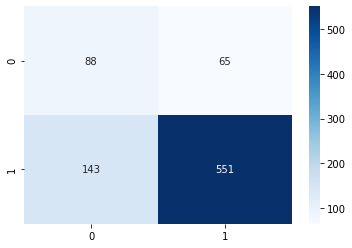

In [45]:
# Confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred, labels=[0,1])
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt='2')

## Visualization

In [46]:
# Font option
title_font = {'weight': 'medium', 'size': 'medium'}
axis_font = {'size': 'small'}

Numero = [x for x in range(EPOCHS)]

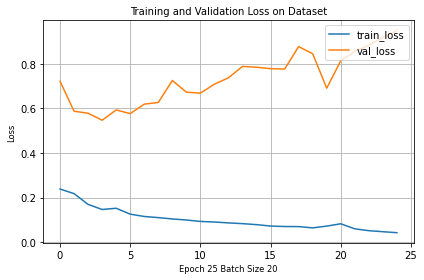

In [47]:
# Plot loss
plt.figure()
plt.plot(Numero, history.history["loss"], label="train_loss")
plt.plot(Numero, history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on Dataset", **title_font)
plt.xlabel(f"Epoch {EPOCHS} Batch Size {BS}", **axis_font)
plt.ylabel("Loss", **axis_font)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()

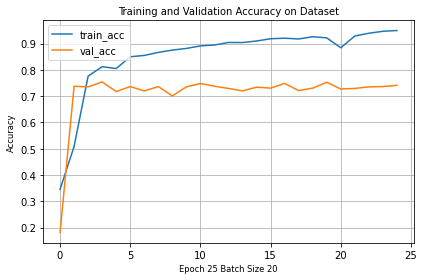

In [48]:
# plot accuracy
plt.figure()
plt.plot(Numero, history.history["accuracy"], label="train_acc")
plt.plot(Numero, history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy on Dataset", **title_font)
plt.xlabel(
    f"Epoch {EPOCHS} Batch Size {BS}", **axis_font)
plt.ylabel("Accuracy", **axis_font)
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid()

## Save Results to CSV

In [ ]:
predictions_lstm = [int(y[0]) for y in np.round(model.predict(X_test))]
results_lstm = pd.DataFrame(zip(test_df["ID"], predictions_lstm), columns=["ID", "Prediksi"])
results_lstm.to_csv("../result/neural_network/result_recurrent_lstm.csv", index=False)

### Note : 
I guess, there are some problems in tokenization process with keras that makes neural network failed predict the label. I need your help :wink: